In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import cartopy.crs as ccrs
import cartopy

from wrf_hr_utils import *
from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat,humidsat
from orographicConvectionTheory.orographicConvectionTheory import *
SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

In [2]:
xr.set_options(display_style='text') 

# Preprocessing for Ahmed POD

In [66]:
deepinput = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/wrfinput_d01')
deepchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/')
deepchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/')
deepchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.precip.days0-250.nc')
deepchannelprecip_hourly=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.precip.hourly.days0-250.nc')


In [6]:
#hrhgt = hrchannel.HGT.isel(south_north=0,Time=-1).persist()
#hrdist=(1635-hrhgt.west_east)*3

In [4]:
pressure=deepchannel_p.P_PL[-1].load()/100
plevs=pressure.assign_attrs({'units':'hPa'})

In [49]:
%%time
deepchannel_p.T_PL[2401:,:,:,1675:].coarsen(Time=6).mean().assign_coords(lev=plevs).swap_dims({'num_press_levels_stag':'lev'}).rename(south_north='lat',west_east='lon',Time='time').to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.6hmean.nc")
deepchannel_p.Q_PL[2401:,:,:,1675:].coarsen(Time=6).mean().assign_coords(lev=plevs).swap_dims({'num_press_levels_stag':'lev'}).rename(south_north='lat',west_east='lon',Time='time').to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.Q_PL.days100-250.6hmean.nc")
deepchannelprecip[-600:,:,1675:].rename(south_north='lat',west_east='lon',Time='time').to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.precip.days100-250.6hmean.nc")


CPU times: user 3min 12s, sys: 49min 19s, total: 52min 31s
Wall time: 49min 58s


In [9]:
xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.6hmean.nc")[:,:,:,:100].to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.6hmean_mtn.nc")
xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/deepchannel.Q_PL.days100-250.6hmean.nc")[:,:,:,:100].to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.Q_PL.days100-250.6hmean_mtn.nc")
xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/deepchannel.precip.days100-250.6hmean.nc")[:,:,:100].to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.precip.days100-250.6hmean_mtn.nc")


In [9]:
%%time
xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.6hmean.nc"  )[:,:,:,-1000:].to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.6hmean_ups.nc")
xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/deepchannel.Q_PL.days100-250.6hmean.nc"  )[:,:,:,-1000:].to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.Q_PL.days100-250.6hmean_ups.nc")
xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/deepchannel.precip.days100-250.6hmean.nc")[:,:,-1000:].to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.precip.days100-250.6hmean_ups.nc")


CPU times: user 2.02 s, sys: 26.8 s, total: 28.8 s
Wall time: 43.3 s


In [9]:
%%time
#deepchannel_p.T_PL[2401:,:,:,-1000:].assign_coords(lev=plevs).swap_dims({'num_press_levels_stag':'lev'}).rename(south_north='lat',west_east='lon',Time='time').to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.hourly_ups.nc")
#deepchannel_p.T_PL[2401:,:,:,-1000:].assign_coords(lev=plevs).swap_dims({'num_press_levels_stag':'lev'}).rename(south_north='lat',west_east='lon',Time='time').to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.hourly_ups.nc")
deepchannelprecip_hourly[-3600:,:,-1000:].rename(south_north='lat',west_east='lon',Time='time').to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.precip.days100-250.hourly_ups.nc")


CPU times: user 772 ms, sys: 12.2 s, total: 12.9 s
Wall time: 18.5 s


In [35]:
xr.open_dataset("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.hourly_ups.nc").sel(lon=slice(0,66),lat=slice(0,11)).to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.hourly_ups_18km.nc")
#xr.open_dataset("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.hourly_ups.nc").sel(lon=slice(0,66),lat=slice(0,11)).to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.hourly_ups_18km.nc")



In [4]:
%time xr.open_dataset("/global/cscratch1/sd/qnicolas/temp/deepchannel.precip.days100-250.hourly_ups.nc").sel(lon=slice(400,796)).coarsen(lat=6,lon=6).mean().to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.precip.days100-250.hourly_ups_18km.nc")


CPU times: user 3.93 s, sys: 3.77 s, total: 7.7 s
Wall time: 9.66 s


In [5]:
pr = xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/deepchannel.precip.days100-250.hourly_ups_18km.nc")
(pr*0.+1).isel(time=0).to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.mask_ups_18km.nc")

In [42]:
xr.open_dataset("/global/cscratch1/sd/qnicolas/temp/deepchannel.mask_ups_18km.nc")

<xarray.Dataset>
Dimensions:  (lat: 11, lon: 66)
Coordinates:
    XLAT     (lat, lon) float32 ...
    XLONG    (lat, lon) float32 ...
Dimensions without coordinates: lat, lon
Data variables:
    RAINNC   (lat, lon) float32 ...

In [29]:
%%time 
ahmed.sel(lon=slice(0,396)).coarsen(lat=6,lon=6).mean().to_netcdf("/global/cscratch1/sd/qnicolas/temp/ahmed.temp.QN_hourly_ups_18km.generated.nc")



CPU times: user 8.97 s, sys: 5.3 s, total: 14.3 s
Wall time: 14.6 s


In [18]:
testold=xr.open_dataset("/global/cscratch1/sd/qnicolas/temp/ahmed.binned.QN_hourly_ups.generated.nc")
testnew=xr.open_dataset("/global/cscratch1/sd/qnicolas/temp/ahmed.binned.QN_hourly_ups_18km.generated.nc")

In [29]:
var='Q2'
print(testold[var].mean(),testnew[var].mean())

<xarray.DataArray 'Q2' ()>
array(142622.68789273) <xarray.DataArray 'Q2' ()>
array(0.)


In [63]:
prs=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/deepchannel.precip.days100-250.hourly_ups.nc").isel(lon=slice(400,800))

In [50]:
thetaes = xr.open_dataset("/global/cscratch1/sd/qnicolas/temp/ahmed.temp.QN_hourly_ups.generated.nc")

In [68]:
bl = 0.5*(thetaes.thetae_bl + thetaes.thetae_lt)/thetaes.thetae_sat_lt -1

In [47]:
def get_binned(a,b,bins):
    print(float(np.nanmin(a)))
    bins=bins[(bins>float(np.nanmin(a)))&(bins<float(np.nanmax(a)))]
    print(bins)
    bin_centers=(bins[1:]+bins[:-1])/2
    digitized = np.digitize(np.array(a), bins)
    bin_means = np.array([np.array(b)[digitized == i].mean() for i in range(1, len(bins))])
    return bin_centers,bin_means

In [69]:
bl.max()

<xarray.DataArray ()>
array(0.0218738)

In [70]:
bl.min()

<xarray.DataArray ()>
array(-0.09566337)

In [ ]:
a,b=get_binned(np.array(bl).reshape(-1),np.array(prs).reshape(-1),np.arange(-0.1,0.03,0.005))
plt.plot(a,b)

-0.09566336854986424
[-0.095 -0.09  -0.085 -0.08  -0.075 -0.07  -0.065 -0.06  -0.055 -0.05
 -0.045 -0.04  -0.035 -0.03 ]


In [107]:
binned=xr.open_dataset("/global/cscratch1/sd/qnicolas/temp/ahmed.binned.QN_hourly_ups_18km.generated.nc")

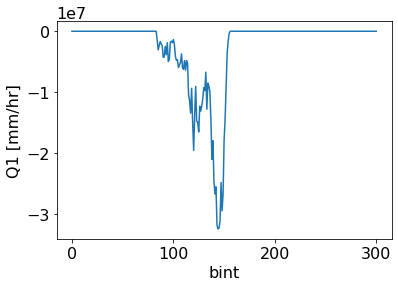

In [ ]:
binned.Q1.plot()

# BL in the mean state

In [4]:
import metpy.calc as mpcalc

In [11]:
from orographicPrecipitation.wrfProcessing.wrf_hr_utils import change_coords_sfc
temp = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.TEMP.days100-250.nc") #Calculated by breaking down means of 50-day intervals
qvapor = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.QVAPOR.days100-250.nc")
pressure = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.PRESSURE.days100-250.nc")
rain = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.precip.days50-200.mean.nc")

In [34]:
dummpy_output = xr.open_dataset("/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.3km/wrfpout_d01_1970-01-01_00_00_00_subset.nc")
tmean_p = change_coords_pl(dummpy_output,xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.T_PL.days100-250.nc"))
qmean_p = change_coords_pl(dummpy_output,xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.Q_PL.days100-250.nc"))


In [47]:
def BL_wrf_sigmalevs(t,q,p,lft_top_pressure):
    t_dew = mpcalc.dewpoint_from_specific_humidity(np.array(q), np.array(t)*units.K, np.array(p)*units.Pa)
    zero_array = 0.*p
    thetae = zero_array+np.array(mpcalc.equivalent_potential_temperature(np.array(p)*units.Pa,
                                                                         np.array(t)*units.K,
                                                                         t_dew
                                                                        )/units.K)
    thetaestar = zero_array+np.array(mpcalc.saturation_equivalent_potential_temperature(np.array(p)*units.Pa,
                                                                                        np.array(t)*units.K
                                                                                       )/units.K)
    
    kappaL=3
    g=9.81
    wB = 0.52
    wL = 1-wB
    thetae0 = 340
    
    thetaeB = thetae[:6].mean('bottom_top')
    thetaeL = thetae[6:].where(pressure[6:]>lft_top_pressure*100).mean('bottom_top')
    thetaeLstar = thetaestar[6:].where(pressure[6:]>lft_top_pressure*100).mean('bottom_top')
    
    capeL  = change_coords_sfc((thetaeB/thetaeLstar - 1)*thetae0)
    subsatL = change_coords_sfc((1 - thetaeL/thetaeLstar)*thetae0)
    BL = g/kappaL/thetae0*(wB*capeL-wL*subsatL)
    
    return BL

In [43]:
BL_700hPa = BL_wrf_sigmalevs(temp,qvapor,pressure,700)
BL_500hPa = BL_wrf_sigmalevs(temp,qvapor,pressure,500)


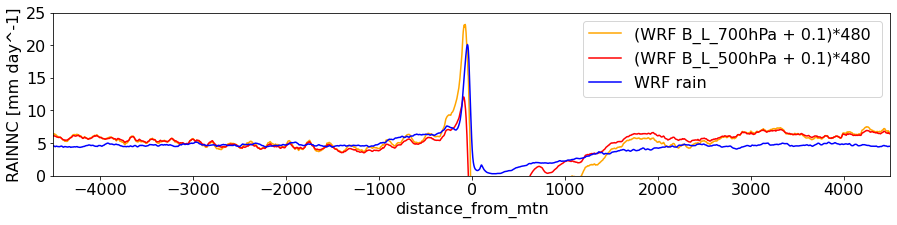

In [39]:
plt.figure(figsize=(15,3))
((BL_700hPa+0.097)*480).plot(label='(WRF B_L_700hPa + 0.1)*480 ',color='orange')
((BL_500hPa+0.075)*480).plot(label='(WRF B_L_500hPa + 0.1)*480 ',color='r')
change_coords_sfc(rain).plot(label='WRF rain',color='b')

plt.ylim(0,25)
plt.xlim(-4500,4500)
plt.legend()